In [ ]:
# ===== CELDA 1: CONFIGURACIÓN Y MONTAJE =====
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Montar Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Directorios ---
DATA_DIR = "/content/drive/MyDrive/Tyre dataset"
DEFECTIVE_DIR = os.path.join(DATA_DIR, "Defective")
GOOD_DIR      = os.path.join(DATA_DIR, "Good")

# --- Parámetros generales ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20
SEED = 42

# --- Fijar semillas para reproducibilidad ---
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- Comprobar GPU ---
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    print("✅ GPU detectada:", device_name[0].name)
else:
    print("⚠️ No se detectó GPU, se usará CPU.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ GPU detectada: /physical_device:GPU:0


In [ ]:
# ===== CELDA 2: DIVISIÓN DE DATOS =====
import glob

# Recolectar rutas de imágenes y etiquetas
image_paths = []
labels = []

for cls_name in ["Good", "Defective"]:
    folder = os.path.join(DATA_DIR, cls_name)
    imgs = glob.glob(os.path.join(folder, "*.jpg")) + \
           glob.glob(os.path.join(folder, "*.png")) + \
           glob.glob(os.path.join(folder, "*.jpeg"))
    image_paths.extend(imgs)
    labels.extend([cls_name] * len(imgs))

print(f"Total de imágenes encontradas: {len(image_paths)}")

# División 70/15/15
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=SEED
)

val_ratio = 0.15 / 0.85
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=val_ratio, stratify=train_labels, random_state=SEED
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Total de imágenes encontradas: 1698
Train: 1188, Val: 255, Test: 255


In [ ]:
# ===== CELDA 3: DATA GENERATORS =====

# Aumentación para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10
)

# Solo normalización para val/test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores desde dataframe simulado
import pandas as pd

train_df = pd.DataFrame({"filename": train_paths, "class": train_labels})
val_df   = pd.DataFrame({"filename": val_paths,   "class": val_labels})
test_df  = pd.DataFrame({"filename": test_paths,  "class": test_labels})

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 1188 validated image filenames belonging to 2 classes.
Found 255 validated image filenames belonging to 2 classes.
Found 255 validated image filenames belonging to 2 classes.


In [ ]:
# ===== CELDA 4: MODELO Y ENTRENAMIENTO =====
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, callbacks

# Cargar modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False  # congelar capas convolucionales

# Añadir capas personalizadas
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (early stopping + mejor modelo)
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_vgg16_model.h5', monitor='val_loss', save_best_only=True)
]

# Entrenamiento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks_list
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7493 - loss: 0.5164

75/75 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.7503 - loss: 0.5146 - val_accuracy: 0.9176 - val_loss: 0.2220
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 125s 893ms/step - accuracy: 0.9075 - loss: 0.2273 - val_accuracy: 0.8980 - val_loss: 0.2277
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.9169 - loss: 0.2294

75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 924ms/step - accuracy: 0.9170 - loss: 0.2289 - val_accuracy: 0.9137 - val_loss: 0.1909
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 889ms/step - accuracy: 0.9354 - loss: 0.1776 - val_accuracy: 0.9333 - val_loss: 0.2000
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.9493 - loss: 0.1550

75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 890ms/step - accuracy: 0.9492 - loss: 0.1551 - val_accuracy: 0.9373 - val_loss: 0.1600
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 878ms/step - accuracy: 0.9437 - loss: 0.1514 - val_accuracy: 0.9333 - val_loss: 0.1668
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.9549 - loss: 0.1203

75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 885ms/step - accuracy: 0.9548 - loss: 0.1204 - val_accuracy: 0.9451 - val_loss: 0.1512
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.9550 - loss: 0.1217

75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 892ms/step - accuracy: 0.9550 - loss: 0.1217 - val_accuracy: 0.9490 - val_loss: 0.1506
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9614 - loss: 0.1191

75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 896ms/step - accuracy: 0.9614 - loss: 0.1190 - val_accuracy: 0.9529 - val_loss: 0.1506
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 892ms/step - accuracy: 0.9666 - loss: 0.1104 - val_accuracy: 0.9529 - val_loss: 0.1540
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 901ms/step - accuracy: 0.9714 - loss: 0.0899 - val_accuracy: 0.9412 - val_loss: 0.1722
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.9762 - loss: 0.0885

75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 896ms/step - accuracy: 0.9760 - loss: 0.0887 - val_accuracy: 0.9569 - val_loss: 0.1490
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 884ms/step - accuracy: 0.9712 - loss: 0.0982 - val_accuracy: 0.9529 - val_loss: 0.1524
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 885ms/step - accuracy: 0.9694 - loss: 0.0778 - val_accuracy: 0.9412 - val_loss: 0.1662
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.9749 - loss: 0.0668

75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 914ms/step - accuracy: 0.9749 - loss: 0.0669 - val_accuracy: 0.9529 - val_loss: 0.1472
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.9793 - loss: 0.0737

75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 900ms/step - accuracy: 0.9794 - loss: 0.0735 - val_accuracy: 0.9490 - val_loss: 0.1457
Epoch 17/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.9782 - loss: 0.0612

75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 901ms/step - accuracy: 0.9781 - loss: 0.0614 - val_accuracy: 0.9529 - val_loss: 0.1451
Epoch 18/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 900ms/step - accuracy: 0.9793 - loss: 0.0666 - val_accuracy: 0.9490 - val_loss: 0.1479
Epoch 19/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 907ms/step - accuracy: 0.9857 - loss: 0.0420 - val_accuracy: 0.9490 - val_loss: 0.1556
Epoch 20/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 902ms/step - accuracy: 0.9818 - loss: 0.0514 - val_accuracy: 0.9490 - val_loss: 0.1587


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.9207 - loss: 0.2167

✅ Test Accuracy: 0.9059 | Loss: 0.2368
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 741ms/step


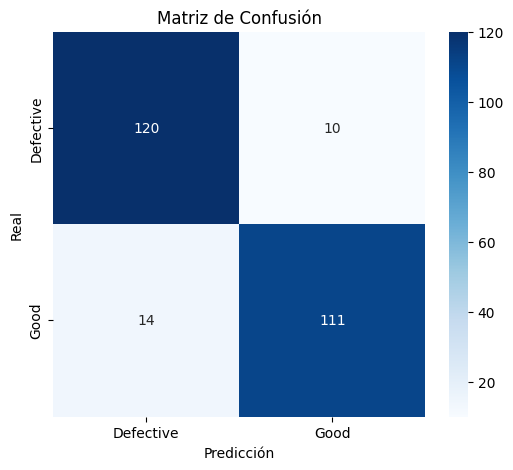


📋 Reporte de Clasificación:
              precision    recall  f1-score   support

   Defective       0.90      0.92      0.91       130
        Good       0.92      0.89      0.90       125

    accuracy                           0.91       255
   macro avg       0.91      0.91      0.91       255
weighted avg       0.91      0.91      0.91       255



In [ ]:
# ===== CELDA 5: EVALUACIÓN COMPLETA =====
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluación
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

# Predicciones
pred_probs = model.predict(test_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Reporte
print("\n📋 Reporte de Clasificación:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


In [ ]:
# ===== CELDA 6: INTERFAZ CON GRADIO =====
import gradio as gr
from tensorflow.keras.preprocessing import image

# Cargar modelo mejor guardado
model = tf.keras.models.load_model("best_vgg16_model.h5")
class_names = list(train_gen.class_indices.keys())

def predict_tyre(img):
    img = img.convert("RGB").resize(IMG_SIZE)
    x = np.expand_dims(np.array(img) / 255.0, axis=0)
    preds = model.predict(x)[0]
    result = {class_names[i]: float(preds[i]) for i in range(len(class_names))}
    return result

iface = gr.Interface(
    fn=predict_tyre,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="🔍 Clasificación de Neumáticos (VGG16)",
    description="Sube una imagen de un neumático para determinar si está en buen estado o defectuoso."
)

iface.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://cc41bfe651f50d76d8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://cc41bfe651f50d76d8.gradio.live
